In [1]:
#Import Libraries
import numpy as np 
from tensorflow import keras
from sklearn.utils import shuffle
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import tensorflow
from keras.applications.vgg16 import VGG16
from keras.layers import Dense
from keras.layers import Flatten
from keras.models import Model
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm

In [8]:
labels = ['NORMAL','PNEUMONIA']

In [34]:
image_data, label_data = [], []
image_size = 150
data_dirs = ["train", "val", "test"]
base_path = "/kaggle/input/chest-xray-pneumonia/chest_xray"

for data_dir in data_dirs:
    for label in labels:
        data_path = os.path.join(base_path, data_dir, label)
        for filename in tqdm(os.listdir(data_path)):
            image = cv2.imread(os.path.join(data_path, filename))
            image = cv2.resize(image, (image_size, image_size))
            image_data.append(image)
            label_data.append(label)

image_data = np.array(image_data)
label_data = np.array(label_data)

100%|██████████| 390/390 [00:02<00:00, 138.63it/s]


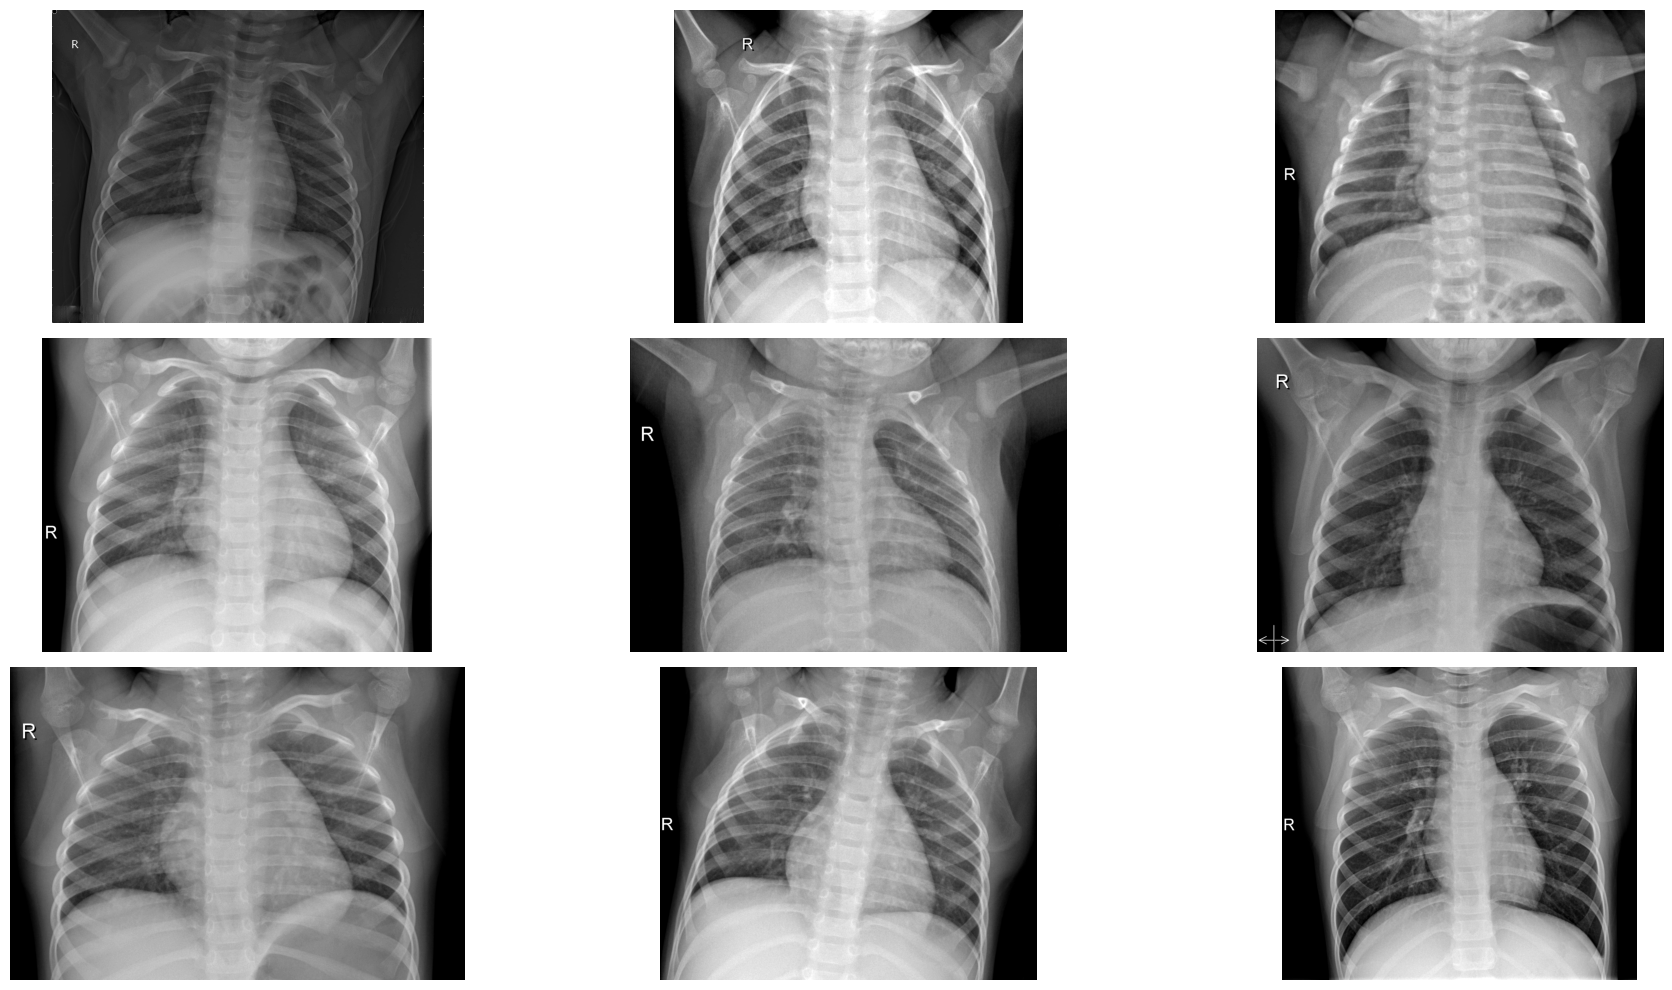

In [35]:
orignal = os.listdir("../input/chest-xray-pneumonia/chest_xray/train/NORMAL")
orignal_dir = "../input/chest-xray-pneumonia/chest_xray/train/NORMAL"

plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(orignal_dir, orignal[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
plt.tight_layout()

In [41]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    samplewise_center=True,
    samplewise_std_normalization=True
)

In [45]:
train_dir = "../input/chest-xray-pneumonia/chest_xray/train"
test_dir = "../input/chest-xray-pneumonia/chest_xray/test"
val_dir = "../input/chest-xray-pneumonia/chest_xray/val"
train = image_generator.flow_from_directory(train_dir, 
                                            batch_size=8, 
                                            shuffle=True, 
                                            class_mode='binary',
                                            target_size=(180, 180))

validation = image_generator.flow_from_directory(val_dir, 
                                                batch_size=1, 
                                                shuffle=False, 
                                                class_mode='binary',
                                                target_size=(180, 180))

test = image_generator.flow_from_directory(test_dir, 
                                            batch_size=1, 
                                            shuffle=False, 
                                            class_mode='binary',
                                            target_size=(180, 180))

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, Activation, GlobalAveragePooling2D

# CNN model
pneumonia_classifier = Sequential()

# Initial Convolutional Block
pneumonia_classifier.add(Conv2D(32, (5, 5), strides=1, padding='valid', input_shape=(180, 180, 3)))
pneumonia_classifier.add(BatchNormalization())
pneumonia_classifier.add(Activation('relu'))
pneumonia_classifier.add(MaxPooling2D(pool_size=(2, 2), strides=2))

# Second Convolutional Block
pneumonia_classifier.add(Conv2D(64, (3, 3), padding='same'))
pneumonia_classifier.add(Activation('relu'))
pneumonia_classifier.add(BatchNormalization())
pneumonia_classifier.add(Conv2D(64, (3, 3), padding='same'))
pneumonia_classifier.add(Activation('relu'))
pneumonia_classifier.add(MaxPooling2D(pool_size=(2, 2)))

# Third Convolutional Block
pneumonia_classifier.add(Conv2D(128, (3, 3), padding='same'))
pneumonia_classifier.add(BatchNormalization())
pneumonia_classifier.add(Activation('relu'))
pneumonia_classifier.add(Conv2D(128, (3, 3), padding='same'))
pneumonia_classifier.add(Activation('relu'))
pneumonia_classifier.add(MaxPooling2D(pool_size=(2, 2)))
pneumonia_classifier.add(Dropout(0.4))  

# Global Average Pooling (reduces overfitting)
pneumonia_classifier.add(GlobalAveragePooling2D())

# Fully Connected Layer
pneumonia_classifier.add(Dense(256))
pneumonia_classifier.add(Activation('relu'))
pneumonia_classifier.add(Dropout(0.5))  

# Output Layer
pneumonia_classifier.add(Dense(1, activation='sigmoid'))

pneumonia_classifier.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [51]:
pneumonia_classifier.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_25 (Conv2D)                   │ (None, 176, 176, 32)        │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 176, 176, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 176, 176, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 88, 88, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 88, 88, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 88, 88, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 88, 88, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 88, 88, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 88, 88, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 44, 44, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 44, 44, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 44, 44, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 44, 44, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 44, 44, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 44, 44, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 313,473 (1.20 MB)

 Trainable params: 313,025 (1.19 MB)

 Non-trainable params: 448 (1.75 KB)

In [58]:
val = pneumonia_classifier.fit(
    train, 
    epochs=25,
    validation_data=validation, 
    steps_per_epoch=100,
    validation_steps=25,
)

Epoch 1/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 71s 699ms/step - accuracy: 0.8855 - loss: 0.2973 - val_accuracy: 0.7500 - val_loss: 0.8476
Epoch 2/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 70s 697ms/step - accuracy: 0.9259 - loss: 0.1900 - val_accuracy: 0.6250 - val_loss: 0.7574
Epoch 3/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 70s 704ms/step - accuracy: 0.8869 - loss: 0.2513 - val_accuracy: 0.5625 - val_loss: 0.6842
Epoch 4/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 69s 691ms/step - accuracy: 0.8858 - loss: 0.2298 - val_accuracy: 0.6250 - val_loss: 1.9785
Epoch 5/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 68s 684ms/step - accuracy: 0.9136 - loss: 0.2070 - val_accuracy: 0.5000 - val_loss: 3.6634
Epoch 6/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 69s 687ms/step - accuracy: 0.9162 - loss: 0.1933 - val_accuracy: 0.5625 - val_loss: 0.9883
Epoch 7/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 36s 353ms/step - accuracy: 0.8961 - loss: 0.2590 - val_accuracy: 0.5000 - val_loss: 2.8384
Epoch 8/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 70s 687ms/step - accuracy: 0.9254 - loss: 0

In [59]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau

# EfficientNet Model
input_layer = Input(shape=(180, 180, 3))
efficientnet_base = EfficientNetB0(weights=None, include_top=False, input_tensor=input_layer)

x = GlobalAveragePooling2D()(efficientnet_base.output)  # Avoids overfitting
x = Dense(512, activation='swish')(x)  
x = Dropout(0.6)(x)  # Prevents overfitting
x = Dense(256, activation='swish')(x)
x = Dropout(0.5)(x)  
output_layer = Dense(1, activation='sigmoid')(x)  

model_effnet = Model(inputs=efficientnet_base.input, outputs=output_layer)

optimizer = RMSprop(learning_rate=0.001, decay=1e-6)
model_effnet.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, verbose=1)

model_effnet.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "functional_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10            │ (None, 180, 180, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 180, 180, 3)    │              0 │ input_layer_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 180, 180, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 181, 181, 3)    │              0 │ normalization[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 90, 90, 32)     │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 90, 90, 32)     │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 90, 90, 32)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 90, 90, 32)     │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 90, 90, 32)     │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 90, 90, 32)     │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand         │ (None, 1, 1, 32)       │            288 │ block1a_se_reduce[0][… │
│ (Conv2D)             

 Total params: 4,837,028 (18.45 MB)

 Trainable params: 4,795,005 (18.29 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [60]:
history = model_effnet.fit(
    train,  
    epochs=25,  
    validation_data=validation,  
    steps_per_epoch=100,  
    validation_steps=25,  
    callbacks=[lr_scheduler]  
)

Epoch 1/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 118s 828ms/step - accuracy: 0.7042 - loss: 0.7604 - val_accuracy: 0.5000 - val_loss: 2.9077 - learning_rate: 0.0010
Epoch 2/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 77s 775ms/step - accuracy: 0.8034 - loss: 0.4454 - val_accuracy: 0.5000 - val_loss: 39.7436 - learning_rate: 0.0010
Epoch 3/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 79s 795ms/step - accuracy: 0.7802 - loss: 0.5693 - val_accuracy: 0.5000 - val_loss: 84.8089 - learning_rate: 0.0010
Epoch 4/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 777ms/step - accuracy: 0.8472 - loss: 0.3672
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
100/100 ━━━━━━━━━━━━━━━━━━━━ 78s 785ms/step - accuracy: 0.8470 - loss: 0.3673 - val_accuracy: 0.5000 - val_loss: 79.1755 - learning_rate: 0.0010
Epoch 5/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 79s 790ms/step - accuracy: 0.8750 - loss: 0.3098 - val_accuracy: 0.5000 - val_loss: 27.4323 - learning_rate: 5.0000e-04
Epoch 6/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 79s 786ms/step - accura

In [69]:
model_effnet.save("effnet_pneumonia_model.h5")

In [70]:
model = tf.keras.models.load_model("effnet_pneumonia_model.h5")